In [1]:
import os
import re
import sys
sys.path.append('..')
import jieba
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
tf.__version__

'2.0.0'

In [3]:
import time
from utils.config import root
from utils.data_helper import data_loader
from collections import namedtuple, defaultdict

In [4]:
vocab_size = 50000
padding_size = 200
BUFFER_SIZE = 3000
BATCH_SIZE = 64

In [6]:
x_train, x_test, y_train, y_test, vocab, mlb = data_loader(vocab_size, padding_size)

In [7]:
y_train = tf.constant(y_train, tf.float32)
y_test = tf.constant(y_test, tf.float32)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [9]:
# 将数据集放入内存加快读取速度
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE)
# 流水线技术 重叠训练的预处理和模型训练步骤。当加速器正在执行训练步骤 N 时，CPU 开始准备步骤 N + 1 的数据。
# 这样做可以将步骤时间减少到模型训练与抽取转换数据二者所需的最大时间（而不是二者时间总和）。
# 没有流水线技术，CPU 和 GPU/TPU 大部分时间将处于闲置状态:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
x, y = next(iter(train_dataset))
x, y

(<tf.Tensor: id=30, shape=(64, 200), dtype=int32, numpy=
 array([[   4,   38,   47, ...,    0,    0,    0],
        [1250,    2,   98, ...,    0,    0,    0],
        [   4,  298,   68, ...,    0,    0,    0],
        ...,
        [1586,  130,    3, ...,    0,    0,    0],
        [   4, 3687,  151, ...,    0,    0,    0],
        [  24,  831, 2848, ..., 1644,  602,  740]], dtype=int32)>,
 <tf.Tensor: id=31, shape=(64, 269), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)

<img src="../data/img/transformer.png" width=400 />

# 创建 transformer

Transformer 包括编码器，解码器和最后的线性层。解码器的输出是线性层的输入，返回线性层的输出。

In [26]:
def get_angles(pos, i, d_model):
    print(pos.shape)
    print(d_model)
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [34]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    print(angle_rads.shape)

    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    print(pos_encoding.shape)

    return tf.cast(pos_encoding, dtype=tf.float32)

(50, 1)
512
(50, 512)
(1, 50, 512)
(1, 50, 512)


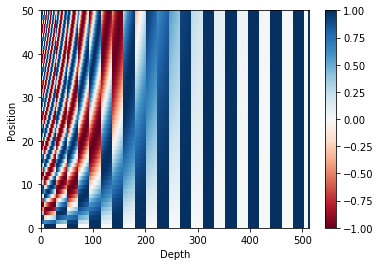

In [35]:
import matplotlib.pyplot as plt
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [33]:
np.arange(512)[np.newaxis, :]

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177